Project Analysis

Short Description:

Analysis is dedicated to modeling and hyperparameter tuning stage, where we used
preprocessed training and testing sets to evaluate our model. 

Pipeline has the following order:

1. Initial Dataset Discovery 
2. Hyperparameter Tuning using Training Set
3. Evaluating Model using AUC PR Metric 

4. Training model on Testing Set with Cross-Validation 
5. Evaluating model using same AUC PR Metric

6. Conclusion

In [1]:
import pandas, numpy
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [2]:
training_set = pandas.read_csv("../processed_data/training_set.csv")
testing_set = pandas.read_csv("../processed_data/testing_set.csv")

print(len(training_set), len(testing_set))


20091 8611


In [3]:
for dataset in [training_set, testing_set]:
    dataset.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
training_set

,annual_income,education_category,living_place,family_size,age,working_years,emp_stability,has_children,owns_realty_and_car,has_contact_information,credit_window,bad_client
0,166500,1.0,5,2.0,28,4,False,False,False,True,45,False
1,110250,1.0,3,1.0,38,15,True,False,True,False,44,False
2,360000,3.0,3,2.0,49,28,True,False,False,True,15,False
3,157500,3.0,5,3.0,38,4,False,True,False,False,10,False
4,135000,3.0,3,2.0,59,10,True,False,False,False,44,False
...,...,...,...,...,...,...,...,...,...,...,...,...
20086,247500,3.0,3,3.0,50,6,True,True,False,True,48,False
20087,180000,1.0,3,2.0,47,15,True,True,False,True,31,False
20088,171000,3.0,3,1.0,53,4,False,False,False,False,28,False
20089,270000,3.0,3,3.0,47,0,False,True,True,True,42,False


Correlation between features

<Axes: >

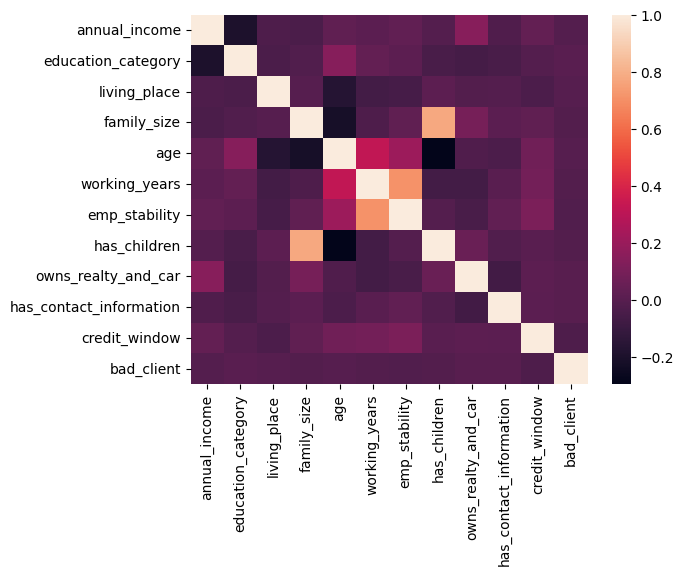

In [5]:
sns.heatmap(training_set.corr())

Initializing XG Boost Classifier

In [6]:
xg_model = xgb.XGBClassifier()

Hyperparameter Tuning for XGBoost Model using GridSearchCV on training set (imbalanced)

In [7]:
x_training, y_training = training_set.drop(columns=['bad_client']), training_set['bad_client']

In [8]:
# Selecting models and apply hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, precision_recall_curve
from scipy import integrate
import numpy

def calculate_auc_pr_score(y_true, y_pred):
    """
    Function calculates auc pr score, based on ROC-AUC
    """
    precisions, recalls, _ = precision_recall_curve(y_true, y_pred)
    sorted_index = numpy.argsort(precisions)
    precisions = numpy.array(precisions)[sorted_index]
    recalls = numpy.array(recalls)[sorted_index]
    return integrate.trapz(x=precisions, y=recalls)
    
score_function = make_scorer(calculate_auc_pr_score)

xg_hyperparams = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.25, 0.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.6, 1.0],
    'max_depth': [3, 4, 5]
}

new_cvs = GridSearchCV( 
    estimator=xg_model,
    param_grid=xg_hyperparams,
    scoring=score_function,
    cv=StratifiedKFold(n_splits=10),
    error_score="raise",
    n_jobs=-1,
)


print('fitting xgboost model....')
new_cvs.fit(x_training, y_training)

# the lower loss score is, the better model performs 

print('selecing optimal parameters...')
optimal_params = new_cvs.best_params_

opt_model = xgb.XGBClassifier(**optimal_params)

fitting xgboost model....
selecing optimal parameters...


In [9]:
print('auc pr score for hp tuning - ', new_cvs.best_score_)

auc pr score for hp tuning -  0.5122784590554625


Cross-validating model on testing set

In [10]:
from sklearn.model_selection import cross_validate 

x_testing, y_testing = testing_set.drop(columns=['bad_client']), testing_set['bad_client']

scores = cross_validate(
    estimator=opt_model,
    X=x_testing,
    y=y_testing,
    scoring=score_function,
)
print('auc-pr score (for cross-validation) - ', numpy.mean(scores['test_score']))

auc-pr score (for cross-validation) -  0.49031392589027456


Saving model object to the Pickle file

In [11]:
# saving machine learning model using pickle 
import pickle 
pickle.dump(opt_model, open("../models/classifier.pkl", mode="wb"))

Conclusion